In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl

In [182]:
import pandas as pd
from pandas import DataFrame

In [2]:
%matplotlib inline

In [9]:
condata=pd.read_csv('TexasCons.csv')

In [3]:
mpl.rcParams['font.size'] = 16.
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['axes.labelsize'] = 10.
mpl.rcParams['xtick.labelsize'] = 12.
mpl.rcParams['ytick.labelsize'] = 12.

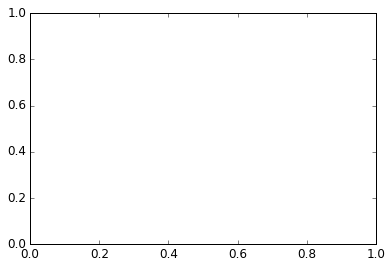

In [4]:
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])

In [5]:
lllat = 25; urlat = 37; lllon = -107; urlon = -93

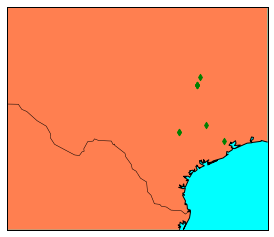

In [73]:
map = Basemap(lon_0=(urlon+lllon)/2, lat_0=(urlat+lllat)/2, 
            llcrnrlat=lllat, urcrnrlat=urlat,llcrnrlon=lllon,urcrnrlon=urlon,resolution='l')
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua',zorder=0)
map.drawcoastlines()
map.drawcountries()
#map.readshapefile('./tl_2013_48_cousub/tl_2013_48_cousub', 'counties')
x, y = map(lons,lats)
map.scatter(x,y,marker='d',color='g')
plt.show()

In [74]:
lons = []
lats = []
count = 0

In [159]:
for point in condata.Coordinates:
    sep = point.strip('[]').split(',')
    lats.append(sep[0])
    lons.append(sep[1])

In [179]:
x, y = map(newlons,newlats)

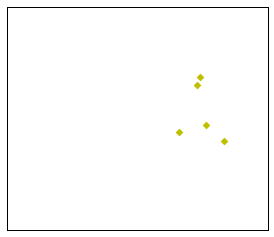

In [180]:
map.scatter(x,y,marker='D',color='y',s=20)
plt.show()

In [107]:
plotdata = condata.Location.value_counts()

In [147]:
plotdata

Dallas, Texas             4
Austin, Texas             2
College Station, Texas    1
Houston, Texas            1
McKinney, Texas           1
Name: Location, dtype: int64

In [172]:
placedict = {}

In [143]:
placedict = dict(list(condata.groupby('Location')))

In [176]:
newlats = []
newlons = []

In [177]:
for spot in plotdata.keys():
    mess = list(placedict[spot].Coordinates)
    sep = mess[0].strip('[]').split(',')
    newlats.append(sep[0])
    newlons.append(sep[1])

In [189]:
df = DataFrame(plotdata, index=[plotdata.keys()])

In [192]:
df['Lat']=newlats
df['Long']=newlons

In [200]:
df

,Location,Lat,Long
"Dallas, Texas",4,32.7762719,-96.7968558
"Austin, Texas",2,30.2711286,-97.7436994
"College Station, Texas",1,30.6262616,-96.3347248
"Houston, Texas",1,29.7589382,-95.3676973
"McKinney, Texas",1,33.1976496,-96.615447


-96.7968558 32.7762719 [0.4,0.8,0.9] 15.0
-97.7436994 30.2711286 [0.4,0.8,0.9] 10.0
-96.3347248 30.6262616 [0.4,0.8,0.9] 7.5
-95.3676973 29.7589382 [0.4,0.8,0.9] 7.5
-96.615447 33.1976496 [0.4,0.8,0.9] 7.5


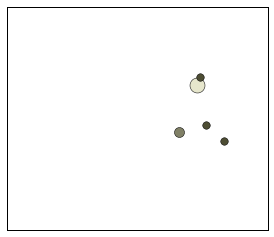

In [298]:
for i,loc in enumerate(df.index):
    x = float(df.Long[i])
    y = float(df.Lat[i])
    r = 0.1 + 0.2*df.Location[i]
    g = 0.1 + 0.2*df.Location[i]
    b = 0.2*df.Location[i]
    size = 5 + df.Location[i]*2.5
    print(x,y,c,size)
    map.plot(x,y,marker='o',color=[r,g,b],ms=size)

-96.7968558 32.7762719 [0.4,0.8,0.9] 15.0
-97.7436994 30.2711286 [0.4,0.8,0.9] 10.0
-96.3347248 30.6262616 [0.4,0.8,0.9] 7.5
-95.3676973 29.7589382 [0.4,0.8,0.9] 7.5
-96.615447 33.1976496 [0.4,0.8,0.9] 7.5


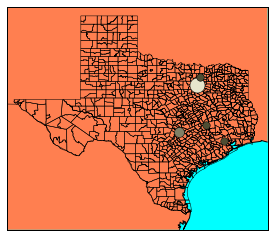

In [299]:
map = Basemap(lon_0=(urlon+lllon)/2, lat_0=(urlat+lllat)/2, 
            llcrnrlat=lllat, urcrnrlat=urlat,llcrnrlon=lllon,urcrnrlon=urlon,resolution='l')
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua',zorder=0)
map.drawcoastlines()
map.drawcountries()
map.readshapefile('./tl_2013_48_cousub/tl_2013_48_cousub', 'counties')
for i,loc in enumerate(df.index):
    x = float(df.Long[i])
    y = float(df.Lat[i])
    r = 0.1 + 0.2*df.Location[i]
    g = 0.1 + 0.2*df.Location[i]
    b = 0.2*df.Location[i]
    size = 5 + df.Location[i]*2.5
    map.plot(x,y,marker='o',color=[r,g,b],ms=size)